## Modules

In [15]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn import metrics

## Preprocessing

In [2]:
#Loading the Dataframe
Dataset_std = pd.read_pickle("Data_te_std.pkl")   #Standardized Dataset
Attack_label = pd.read_pickle("Attack_label.pkl") #Attack Labels 0:Normal, 1:Attack
Attack_type_raw = pd.read_pickle("Attack_type.pkl")   #Attack Types 
mapping_dict = {'DDoS_UDP': 1, 'DDoS_ICMP': 1, 'DDoS_HTTP': 1, 'DDoS_TCP': 1,
                'Port_Scanning': 2, 'Fingerprinting': 2, 'Vulnerability_scanner': 2,
                'MITM' : 3, 'XSS' : 4, 'SQL_injection': 4, 'Uploading':4, 
                'Backdoor': 5, 'Password': 5, 'Ransomware':5, 'Normal':6}
Attack_type = Attack_type_raw.map(mapping_dict)

# Joining Dataset_std and Attack_type
Dataset_std['Attack_type'] = Attack_type

#Oversampling the minority classes
Dataset, Target_label = SMOTEENN(random_state= 22).fit_resample(Dataset_std, Attack_label)
Target_type = Dataset['Attack_type']
Dataset = Dataset.drop(columns = 'Attack_type')

#Splitting the dataset into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(Dataset, Target_label, train_size=5000, test_size=60000, random_state=22) # stratify= Target_type / Target_label
_, _, Y_ref, _ = train_test_split(Dataset, Target_type, train_size=5000 ,test_size=60000, random_state=22)


In [16]:
pca = PCA(n_components=10)
X_train_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.transform(X_test)

## Functions

In [21]:
#Function to get the indices of the attack type
def get_index(attack_type: int, data: np.ndarray) -> np.ndarray:
    indices = np.where(data[:] == attack_type)[0]
    return indices  

#Function to remove a attack type from the dataframe
def remove_attack_type(data_X: np.ndarray, attack_type: int) -> np.ndarray:
    indices_to_remove = get_index(attack_type, Y_ref)
    new_data = np.delete(data_X, indices_to_remove, axis=0)
    return new_data

#Function for Evaluation
def evaluate_bin(test: np.ndarray, pred: np.ndarray, display:bool = True) -> None:
    df_metric = pd.DataFrame({'Average Accuracy Score': metrics.accuracy_score(test, pred)*100,                              
                              'Precision':metrics.precision_score(test, pred, pos_label= 1, average = 'binary')*100,
                              'Recall': metrics.recall_score(test, pred, pos_label= 1, average = 'binary')*100,
                              'F1-Score': metrics.f1_score(test, pred, pos_label= 1, average = 'binary' )*100}, 
                              index= ['Anomaly'])
    if display:
        metrics.ConfusionMatrixDisplay.from_predictions(test, pred, normalize= 'true',  display_labels=['Normal', 'Abnormal'])
    return df_metric

#Function for looping training and testing
def train_and_eval(model, x, y, norm: bool = False, pca:bool = False) -> pd.DataFrame:
    if norm:
        norm_x_test = normalize(X_test, norm='l2')
        y_pred =  model.fit(normalize(x, norm='l2'), y).predict(norm_x_test)
        return evaluate_bin(norm_x_test, y_pred, False)
    if pca:
        model.fit(X_train_PCA, y).predict(X_test_PCA)
        return evaluate_bin(Y_test, y_pred, False)
    y_pred = model.fit(x, y).predict(X_test)
    return evaluate_bin(Y_test, y_pred, False)

In [4]:
#Modal definition
svc = SVC(kernel='rbf', C=500, probability=True)
rf = RandomForestClassifier(criterion= 'gini', max_depth= None, max_features= 0.8, max_samples= 0.8, n_estimators= 80, random_state=22)
knn = KNeighborsClassifier(leaf_size= 5, n_neighbors= 8, p= 1, weights= 'distance')
lof = LocalOutlierFactor(n_neighbors=6, novelty=True, metric= 'euclidean', leaf_size=20)
vote_clf = VotingClassifier(estimators=[('svc', svc), ('knn', knn), ('rf', rf)], voting='soft') 

## Voting Ensemble Binary

In [22]:
# Binary Classifiers
models = {'SVC':svc, 'KNN':knn, 'Random Forest':rf, 'Voting Ensemble':vote_clf}
clf_results = pd.DataFrame()
clf_results_norm = pd.DataFrame()
clf_results_pca = pd.DataFrame()

for model_name, model in models.items(): 
    clf_results = pd.concat([clf_results, train_and_eval(model, X_train, Y_train)], axis=0, ignore_index=True)
    clf_results_norm = pd.concat([clf_results_norm, train_and_eval(model, X_train, Y_train, True)], axis=0, ignore_index=True)
    clf_results_pca = pd.concat([clf_results_pca, train_and_eval(model, X_train, Y_train), False, True], axis=0, ignore_index=True)

#LOF
train = normalize(X_train, norm="l2")
train = train[Y_train == 0]
test_x = normalize(X_test, norm="l2")
test = (((Y_test*2)-1)*-1)
pred = lof.fit(train).predict(test_x)

clf_results = pd.concat([clf_results, pd.DataFrame({'Average Accuracy Score': metrics.accuracy_score(test, pred)*100,                              
                              'Precision':metrics.precision_score(test, pred, pos_label= -1, average = 'binary')*100,
                              'Recall': metrics.recall_score(test, pred, pos_label= -1, average = 'binary')*100,
                              'F1-Score': metrics.f1_score(test, pred, pos_label= -1, average = 'binary' )*100},
                              index= ['LOF'])], axis=0, ignore_index=True)

clf_results.index = pd.MultiIndex.from_product([['SVC', 'KNN', 'Random Forest', 'Voting Ensemble', 'LOF']] ,names=['Model'])
clf_results_norm.index = pd.MultiIndex.from_product([['SVC', 'KNN', 'Random Forest', 'Voting Ensemble']] ,names=['Model'])
clf_results_pca.index = pd.MultiIndex.from_product([['SVC', 'KNN', 'Random Forest', 'Voting Ensemble']] ,names=['Model'])
print(clf_results)
print(clf_results_norm)
print(clf_results_pca)

ValueError: Classification metrics can't handle a mix of continuous-multioutput and binary targets

,Average Accuracy Score,Balanced Accuracy Score,Precision,Recall,F1-Score
Anomaly,92.111667,92.111667,94.570471,89.353333,91.887908


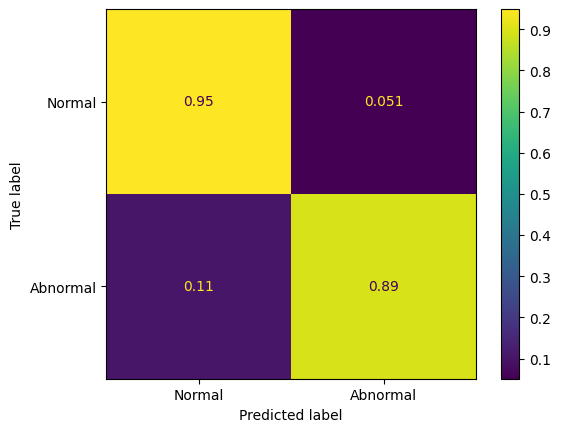

In [20]:
#Voting Classifier
Y_pred = vote_clf.fit(X_train, Y_train).predict(X_test)

#Evaluation
evaluate_bin(Y_test, Y_pred)

## Novel Attack Tests

In [21]:
#Training set without the novel attack types
X_train_nov1 = remove_attack_type(np.array(X_train), 1)
Y_train_nov1 = remove_attack_type(np.array(Y_train), 1)
X_train_nov2 = remove_attack_type(np.array(X_train), 2)
Y_train_nov2 = remove_attack_type(np.array(Y_train), 2)
X_train_nov3 = remove_attack_type(np.array(X_train), 3)
Y_train_nov3 = remove_attack_type(np.array(Y_train), 3)
X_train_nov4 = remove_attack_type(np.array(X_train), 4)
Y_train_nov4 = remove_attack_type(np.array(Y_train), 4)
X_train_nov5 = remove_attack_type(np.array(X_train), 5)
Y_train_nov5 = remove_attack_type(np.array(Y_train), 5)

trainings = [(X_train_nov1, Y_train_nov1), (X_train_nov2, Y_train_nov2), (X_train_nov3, Y_train_nov3),
             (X_train_nov4, Y_train_nov4), (X_train_nov5, Y_train_nov5)]
models = {'SVC':svc, 'KNN':knn, 'Random Forest':rf, 'Voting Ensemble':vote_clf}

model_results = pd.DataFrame()
for model_name, model in models.items(): 
    result = pd.DataFrame()
    for i, (x, y) in enumerate(trainings):
        result = pd.concat([result, train_and_eval(model, x, y)], axis=0, ignore_index=True)
    model_results = pd.concat([model_results, result], axis=0)
    
model_results.index = pd.MultiIndex.from_product([models.keys(), ['novel type 1', 'novel type 2', 'novel type 3', 'novel type 4', 'novel type 5']],
                                                 names=['Model', 'Novel Type'])

model_results


Average Accuracy Score  Balanced Accuracy Score  \
Model           Novel Type                                                      
SVC             novel type 1               80.048333                80.048333   
                novel type 2               81.333333                81.333333   
                novel type 3               81.483333                81.483333   
                novel type 4               80.440000                80.440000   
                novel type 5               81.100000                81.100000   
KNN             novel type 1               81.868333                81.868333   
                novel type 2               82.203333                82.203333   
                novel type 3               82.151667                82.151667   
                novel type 4               82.898333                82.898333   
                novel type 5               80.518333                80.518333   
Random Forest   novel type 1               91.195000                91.195000   
                novel type 2               92.816667                92.816667   
                novel type 3               95.786667                95.786667   
                novel type 4               95.230000                95.230000   
                novel type 5               95.678333                95.678333   
Voting Ensemble novel type 1               91.450000                91.450000   
                novel type 2               91.701667                91.701667   
                novel type 3               91.991667                91.991667   
                novel type 4               87.216667                87.216667   
                novel type 5               86.523333                86.523333   

                              Precision     Recall   F1-Score  
Model           Novel Type                                     
SVC             novel type 1  97.248283  61.846667  75.608712  
                novel type 2  90.713791  69.813333  78.902954  
                novel type 3  90.246293  70.596667  79.221216  
                novel type 4  98.108735  62.076667  76.040178  
                novel type 5  92.355184  67.813333  78.204044  
KNN             novel type 1  86.075997  76.036667  80.745474  
                novel type 2  84.796859  78.476667  81.514438  
                novel type 3  84.429770  78.843333  81.540981  
                novel type 4  91.765054  72.283333  80.867409  
                novel type 5  89.198099  69.446667  78.092846  
Random Forest   novel type 1  95.270889  86.693333  90.779944  
                novel type 2  95.193864  90.186667  92.622642  
                novel type 3  95.504539  96.096667  95.799688  
                novel type 4  97.212944  93.130000  95.127681  
                novel type 5  96.135071  95.183333  95.656835  
Voting Ensemble novel type 1  97.123693  85.430000  90.902320  
                novel type 2  94.848539  88.193333  91.399948  
                novel type 3  94.581874  89.086667  91.752064  
                novel type 4  98.350078  75.703333  85.553379  
                novel type 5  95.385635  76.760000  85.065199

<Axes: title={'center': 'F1-Score of Models on Novel Attack Types'}, xlabel='Model'>

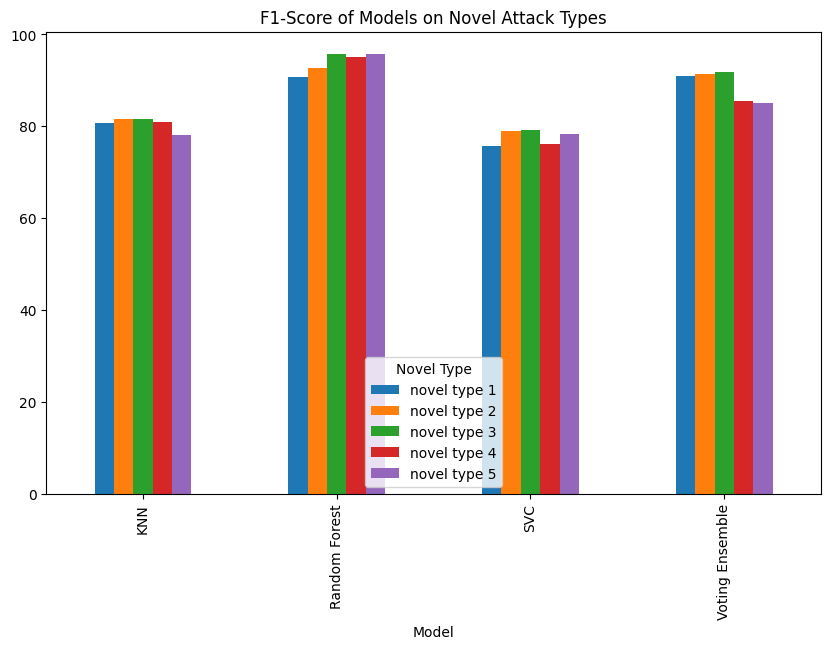

In [22]:
model_results['F1-Score'].unstack().plot(kind='bar', figsize=(10, 6), title='F1-Score of Models on Novel Attack Types')

<Axes: title={'center': 'Balanced Accuracy Score of Models on Novel Attack Types'}, xlabel='Model'>

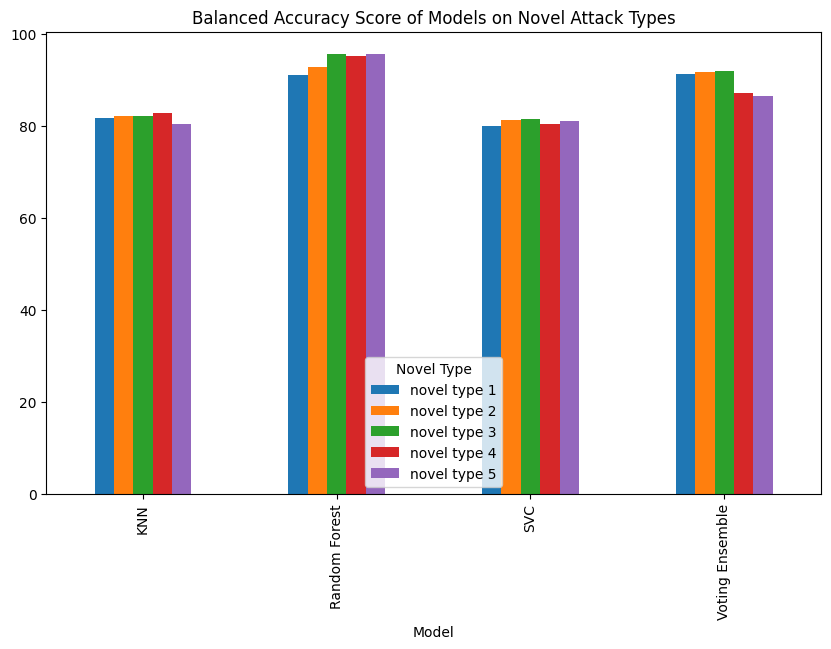

In [23]:
model_results['Balanced Accuracy Score'].unstack().plot(kind='bar', figsize=(10, 6), title='Balanced Accuracy Score of Models on Novel Attack Types')